In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F

device=torch.device("cpu")


*recreating model architecture and SE block*

In [2]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.fc(x)


In [3]:

def get_model_mobilenet_v2(num_classes, pretrained=False, se=True):
    model = models.mobilenet_v2(weights=None)
    if se:
        last_conv_ch = model.features[-1][0].out_channels
        model.features.add_module('se_block', SEBlock(last_conv_ch))
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(nn.Dropout(
        0.2), nn.Linear(in_features, num_classes))
    return model

In [4]:
# use the same number of classes as training
num_classes = 23

model = get_model_mobilenet_v2(
    num_classes=num_classes, pretrained=False, se=True)
model.load_state_dict(torch.load(
    'best_mobilenetv2_mose.pth', map_location=torch.device('cpu')))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
# image transform must match test/val augmentation
transform = transforms.Compose([
    transforms.Resize(int(224 * 1.14)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

*these custom data have been taken from plantvillage dataset (kaggle)*
*in some, model shown accuracy of 99.99%, in others not*

testing of model done on 
*Plant Disease Classification Merged Dataset (PDCMD)* and *plant leaf disease training dataset (PLDTD)*



In [6]:

img_path = "custom/sug_rust_PLDTD.jpeg"  
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0) 

# predict
# with torch.no_grad():
#     output = model(input_tensor)
#     probs = torch.nn.functional.softmax(output, dim=1)
#     pred_idx = torch.argmax(probs, dim=1).item()
#     confidence = probs[pred_idx].item() * 100 

with torch.no_grad():
    output = model(input_tensor)
    probs = torch.nn.functional.softmax(output, dim=1)[0]
    pred_idx = torch.argmax(probs).item()
    confidence = probs[pred_idx].item() * 100

In [7]:
disease_classes = ['soybean_Bacterial Blight', 'soybean_Brown Spot', 'soybean_Crestamento', 'soybean_Ferrugen', 'soybean_Mossaic Virus', 'soybean_Powdery Mildew', 'soybean_Septoria', 'soybean_Southern_Blight', 'soybean_Sudden Death Syndrome', 'soybean_Yellow Mosaic', 'sugarcane_Banded Chlorosis', 'sugarcane_Brown Rust', 'sugarcane_Brown Spot', 'sugarcane_Dried Leaves', 'sugarcane_Grassy shoot', 'sugarcane_Healthy', 'sugarcane_Mosaic', 'sugarcane_Pokkah Boeng', 'sugarcane_Red Rot', 'sugarcane_Sett Rot', 'sugarcane_Smut', 'sugarcane_Viral Disease', 'sugarcane_Yellow Leaf']
print(f"Predicted class: {disease_classes[pred_idx]}")
print(f'Confidence:{confidence:.2f}%')


Predicted class: sugarcane_Brown Rust
Confidence:99.93%


*for gradcam*


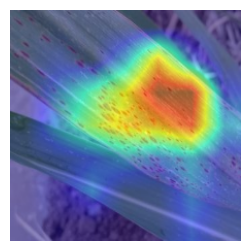

In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

original_img=cv2.imread(img_path)
rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img_float = np.float32(rgb_img) / 255


# taking the last conv layer
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# generating heatmap
targets = [ClassifierOutputTarget(pred_idx)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

# overlay of heatmap
visualization = show_cam_on_image(rgb_img_float, grayscale_cam, use_rgb=True)

# --- Display ---
plt.figure(figsize=(3,3))
plt.imshow(visualization)
plt.axis('off')
plt.show()
